The reading cost time 0.0362 secs
preprocessing dataset, shape=(15558, 14767)


... storing 'batch' as categorical
... storing 'celltype_orig' as categorical
... storing 'celltype' as categorical
/home/yxh/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


version 0.0.2. 09:00, 12/01/2020
Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (0, 4)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (1, 4)
Processing datasets (2, 3)
Processing datasets (2, 4)
Processing datasets (3, 4)
12516 cells defined as MNNs
Calculating KNNs...
2251 cells defined as KNNs
Total cells for training:14767
Reorder
using learning rate  0.001
Training neural network
Epoch 1/2
231/231 [==============================] - 3s 8ms/step - loss: 0.8127
Epoch 2/2
462/462 [==============================] - 1s 1ms/step
version 0.0.2. 09:00, 12/01/2020
Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (0, 4)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (1, 4)
Processing datasets (2, 3)
Processing datasets (2, 4)
Processing datasets (3, 4)
12514 cells defined as MNNs
Calculating KNNs

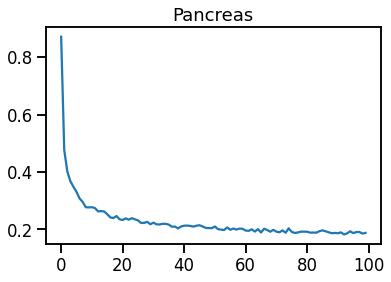

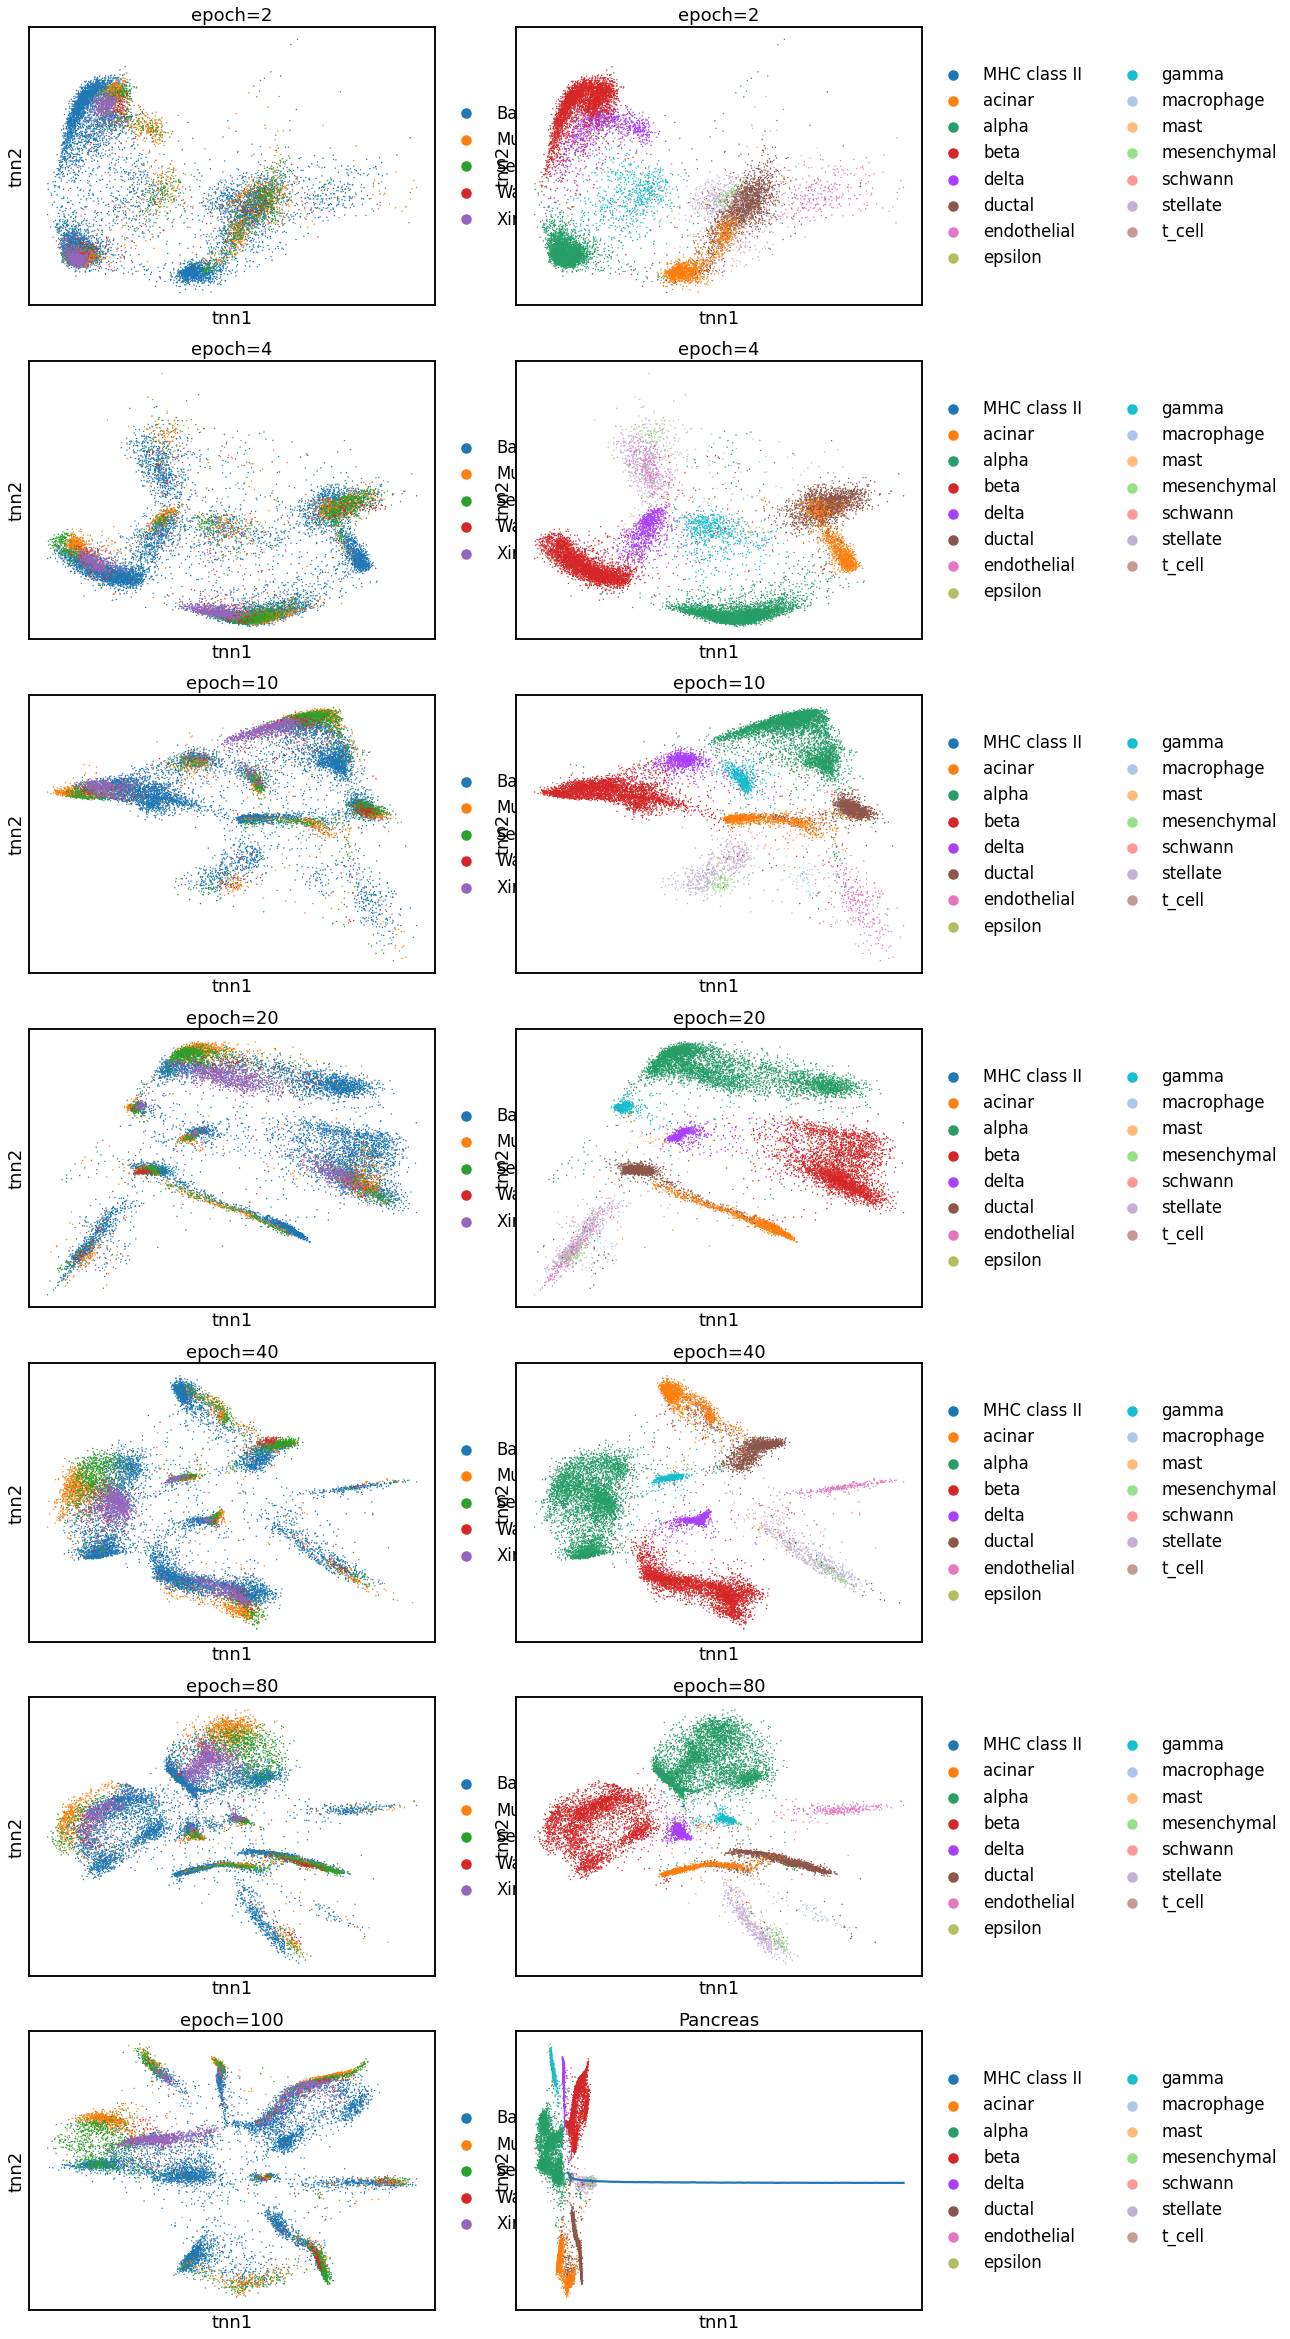

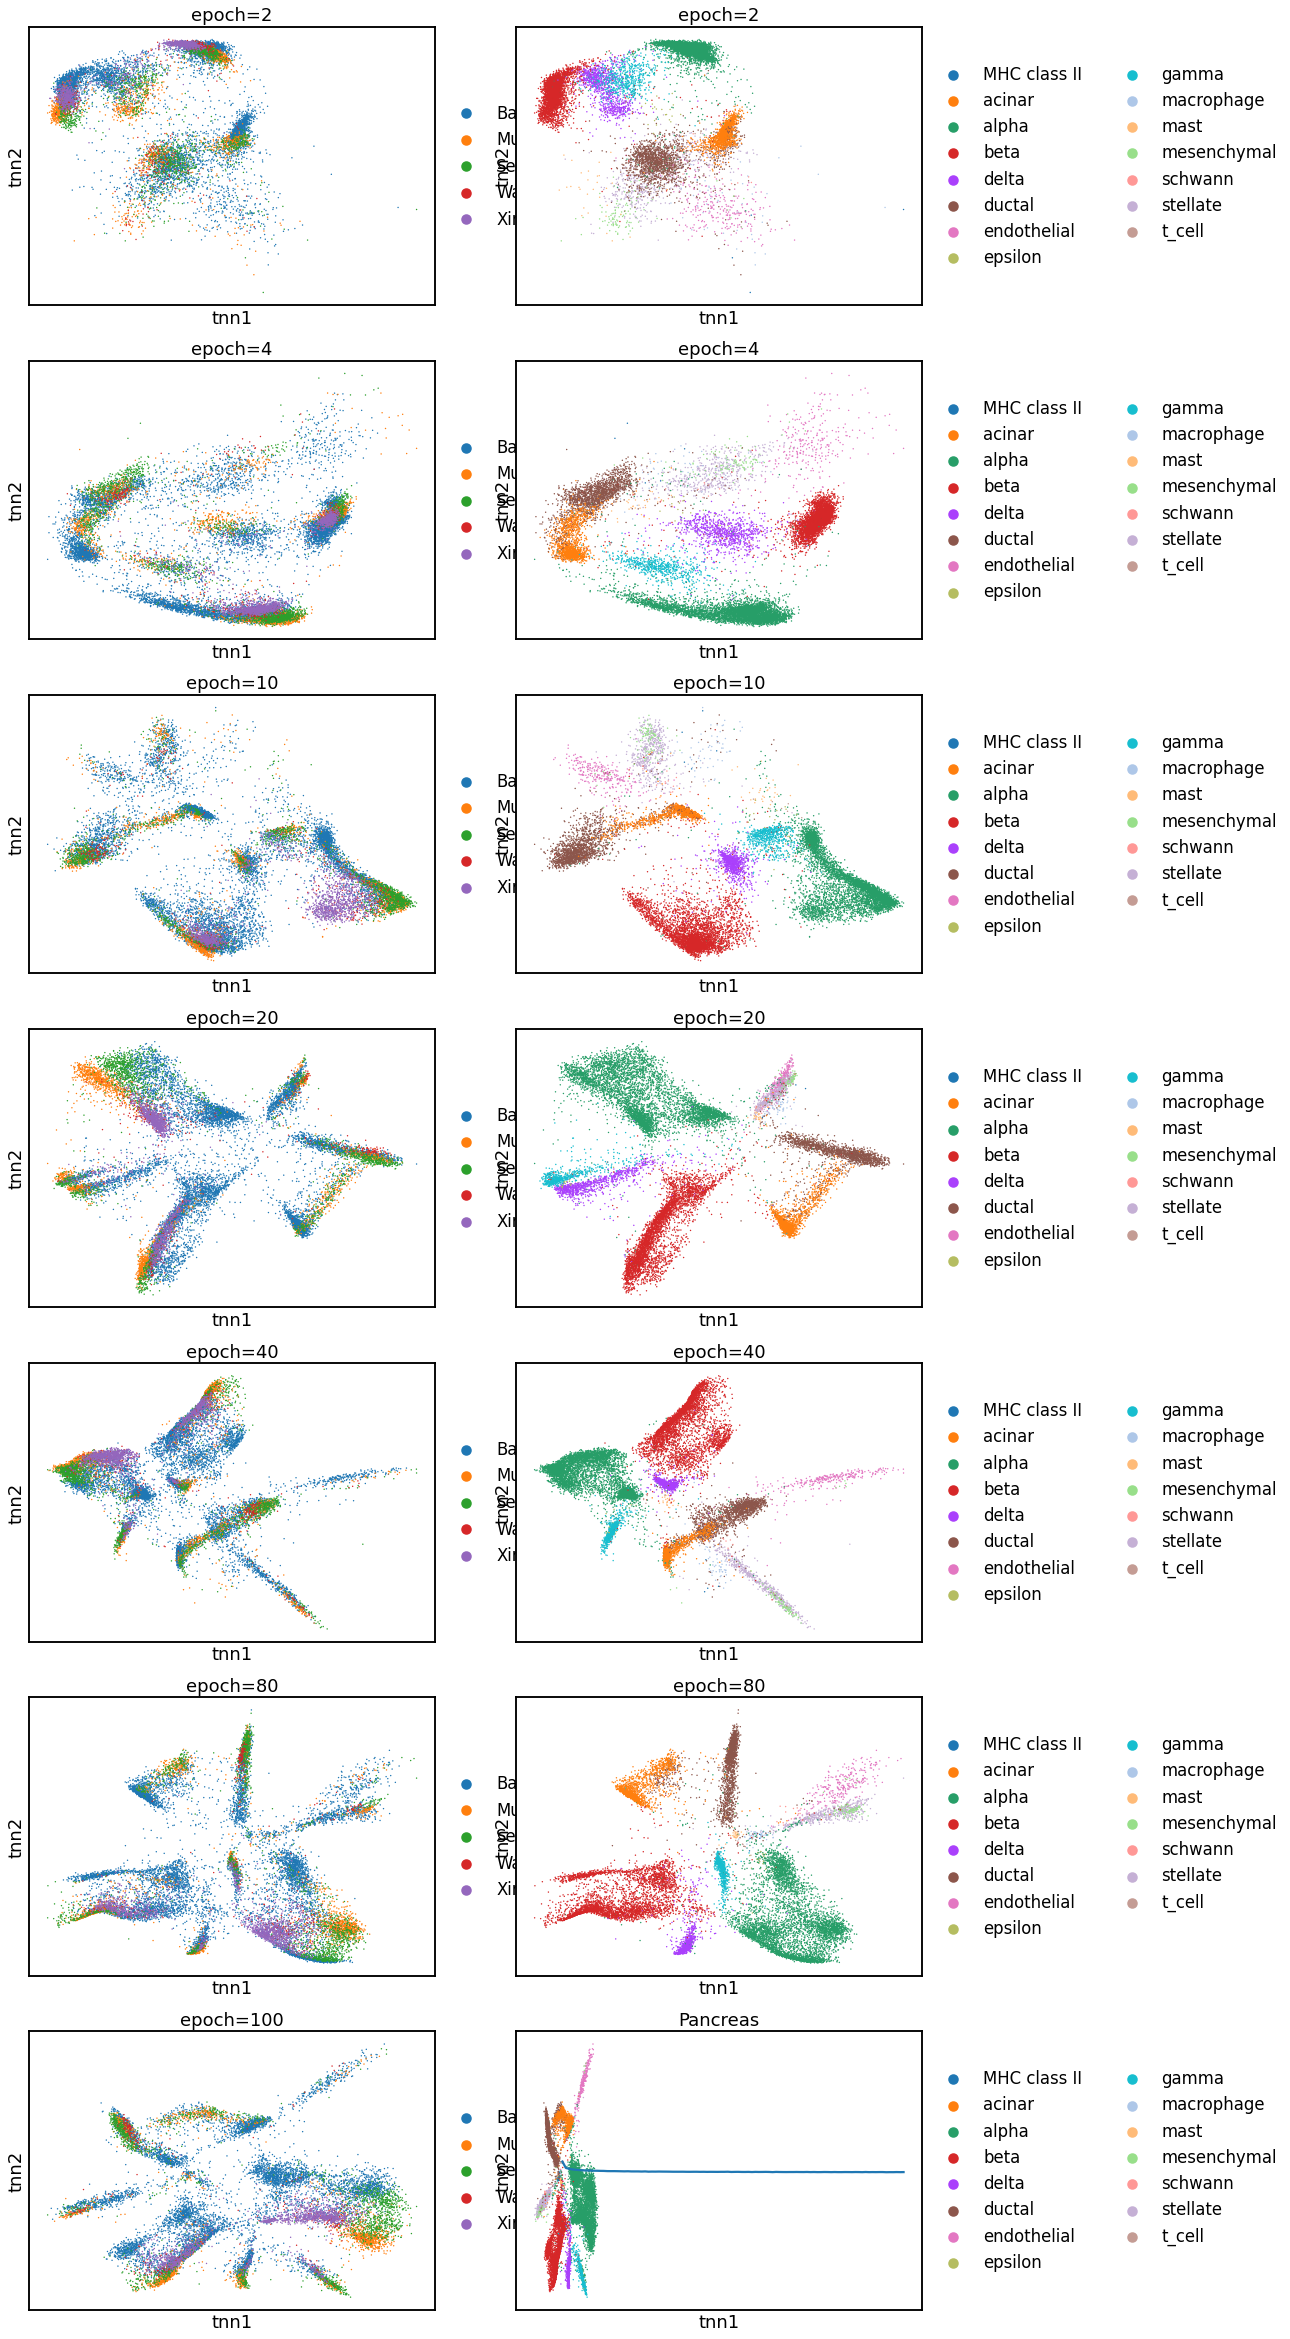

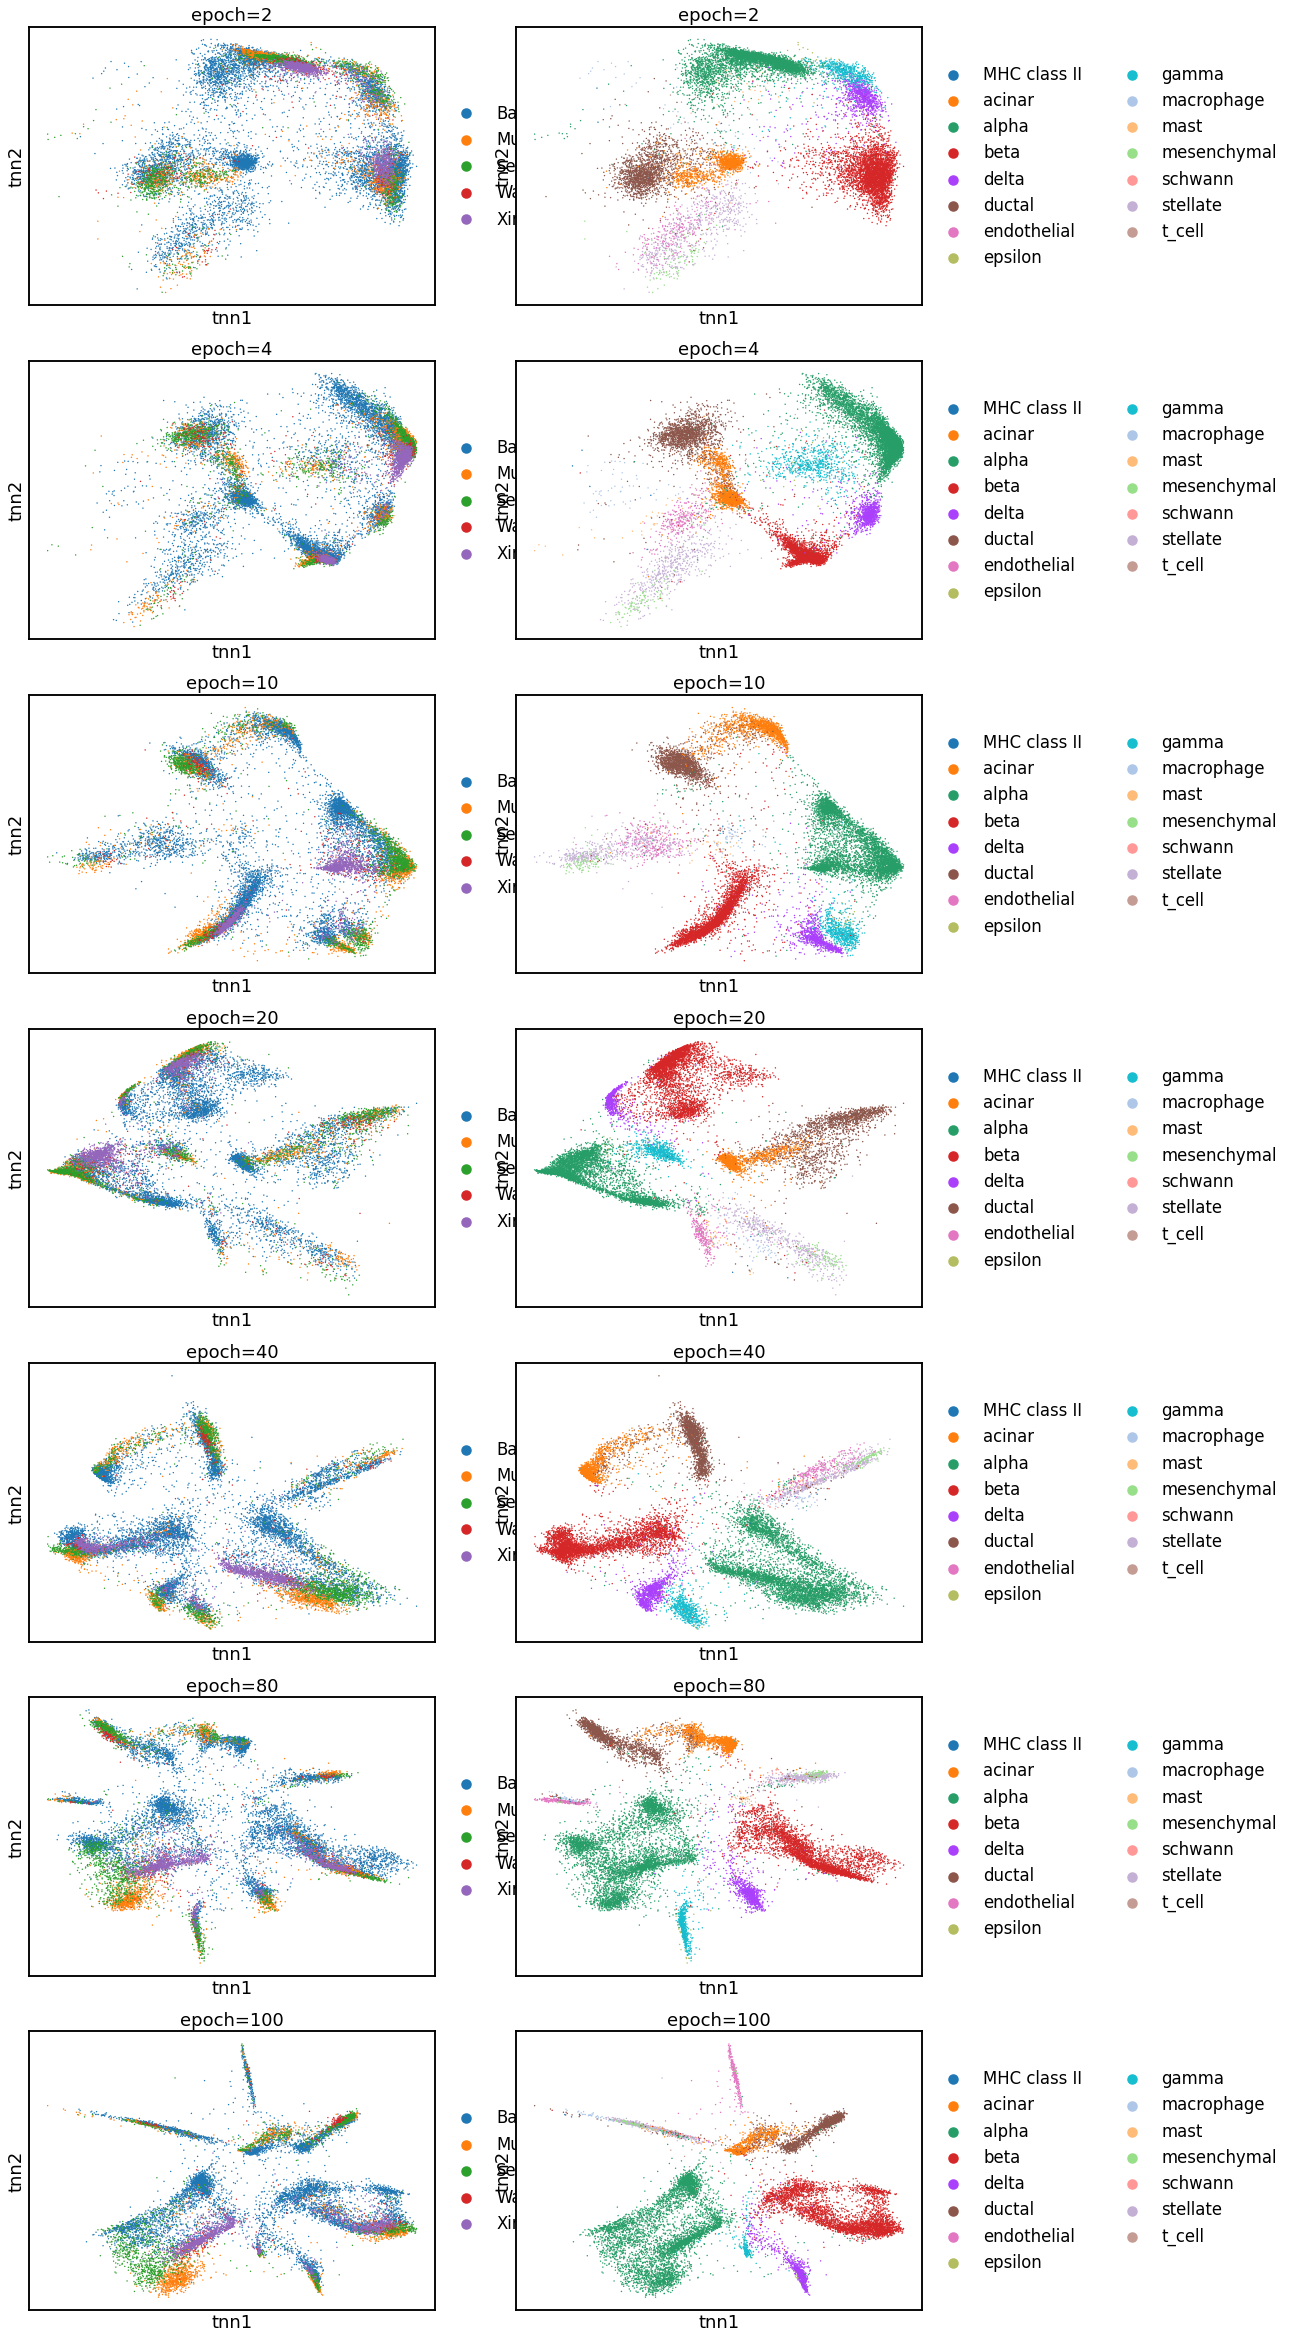

In [7]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy.sparse as sps

from os.path import join
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import sys
from pathlib import Path
from os.path import join
cur_dir = Path(os.getcwd())
sys.path.append(str(cur_dir.parent.parent.absolute()))
from tnn.tnn import *

from moco.kbet import calculate_kbet
from moco.utils import py_read_data, load_meta_txt
from moco.evaluation import scib_process 
from moco.prepare_dataset import prepare_dataset
from moco.preprocessing import preprocess_dataset
from scib_eval import scib_eval

data_dir = '/home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Script/sapling/GLOBE/data'
out_dir = '/home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Output'



# ================================
# prepare datasets
# ================================
dno = 'Pancreas'

n_hvgs = 2000
scale = False
batch_key = 'batchlb'
label_key = 'CellType'

dataset_dir = join(data_dir, dno)
sps_x, genes, cells, df_meta = prepare_dataset(dataset_dir)
X, cell_name, gene_name, df_meta = preprocess_dataset(
    sps_x, 
    cells, 
    genes, 
    df_meta, 
    n_hvgs, 
    scale, 
)

adata = sc.AnnData(X)
adata.var_names = gene_name
adata.obs = df_meta.copy()

sc.pp.scale(adata, max_value=None)
sc.tl.pca(adata, n_comps=50)

# repeat 
lr = 1e-3
log_dir = f'./outputs/{dno}-lr={lr}'
n_repeat = 3
for ri in range(n_repeat):
    os.makedirs(join(log_dir, f'results{ri+1}'), exist_ok=True)

    # training
    EPS = [0, 10, 20, 40, 80, 100, 120]
    EMBS_INSCT = []
    RES_INSCT = None
    for ep in EPS:
        ad_ep = adata.copy()
        model = TNN(lr=lr, epochs=ep, n_epochs_without_progress=ep)  # default lr=1e-3
        model.fit(X = ad_ep, batch_name=batch_key)

        tmp_emb = model.transform(X = ad_ep)
        EMBS_INSCT.append(tmp_emb)
        
    fig = plt.plot(model.loss_history_)
    plt.savefig(join(log_dir, f'results{ri+1}/loss_curve.png'), facecolor='white')
    plt.title(dno)

    np.save(join(log_dir, f'results{ri+1}', 'loss.npy'), model.loss_history_)

    # evaluation
    ADAS_INSCT = []
    for i, ep in enumerate(EPS):
        ad_tmp = sc.AnnData(EMBS_INSCT[i])
        ad_tmp.obs = df_meta.copy()
        ad_tmp.obsm["X_emb"] = ad_tmp.X
        ad_tmp.write(join(log_dir, f'results{ri+1}/ad_{ep}.h5ad'))
        ADAS_INSCT.append(ad_tmp)
        
        tmp_res = scib_eval(ad_tmp, batch_key, label_key)

        RES_INSCT = tmp_res if RES_INSCT is None else RES_INSCT.merge(tmp_res, left_index=True, right_index=True, how='inner')

    RES_INSCT.columns = EPS
    RES_INSCT.to_csv(join(log_dir, f'results{ri+1}/eval.csv'), index=True)

    # Show plots
    # ================================
    fig2, axes = plt.subplots(len(EPS), 2, figsize=(16, 6*len(EPS)))
    for i, idx in enumerate(EPS):
        adata.obsm["X_tnn"] = EMBS_INSCT[i]

        sc.pl.embedding(adata, basis='tnn', color=[batch_key], show=False, ax=axes[i, 0])
        sc.pl.embedding(adata, basis='tnn', color=[label_key], show=False, ax=axes[i, 1])

        axes[i, 0].set_title(f'epoch={idx}')
        axes[i, 1].set_title(f'epoch={idx}')
        
    fig2.savefig(join(log_dir, f'results{ri+1}/umap.png'), facecolor='white')

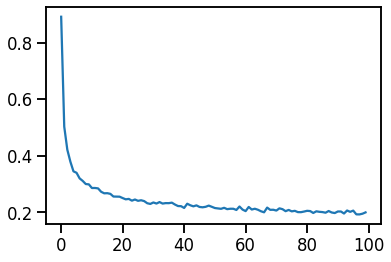

In [5]:
plt.plot(model.loss_history_)

In [3]:
RES_INSCT

2         4         10        40        80   \
NMI_cluster/label          0.680533  0.694113  0.724686  0.722817  0.737971   
ARI_cluster/label          0.474850  0.546457  0.532387  0.468192  0.480208   
ASW_label                  0.712390  0.676880  0.628188  0.656866  0.562465   
ASW_label/batch            0.738168  0.710886  0.671223  0.693357  0.708789   
isolated_label_F1               NaN       NaN       NaN       NaN       NaN   
isolated_label_silhouette       NaN       NaN       NaN       NaN       NaN   
graph_conn                      NaN       NaN       NaN       NaN       NaN   
trajectory                      NaN       NaN       NaN       NaN       NaN   
kBET                       0.400149  0.477890  0.441593  0.442405  0.394935   

                                100  
NMI_cluster/label          0.730490  
ARI_cluster/label          0.525678  
ASW_label                  0.595094  
ASW_label/batch            0.683028  
isolated_label_F1               NaN  
isolated_label_silhouette       NaN  
graph_conn                      NaN  
trajectory                      NaN  
kBET                       0.388027

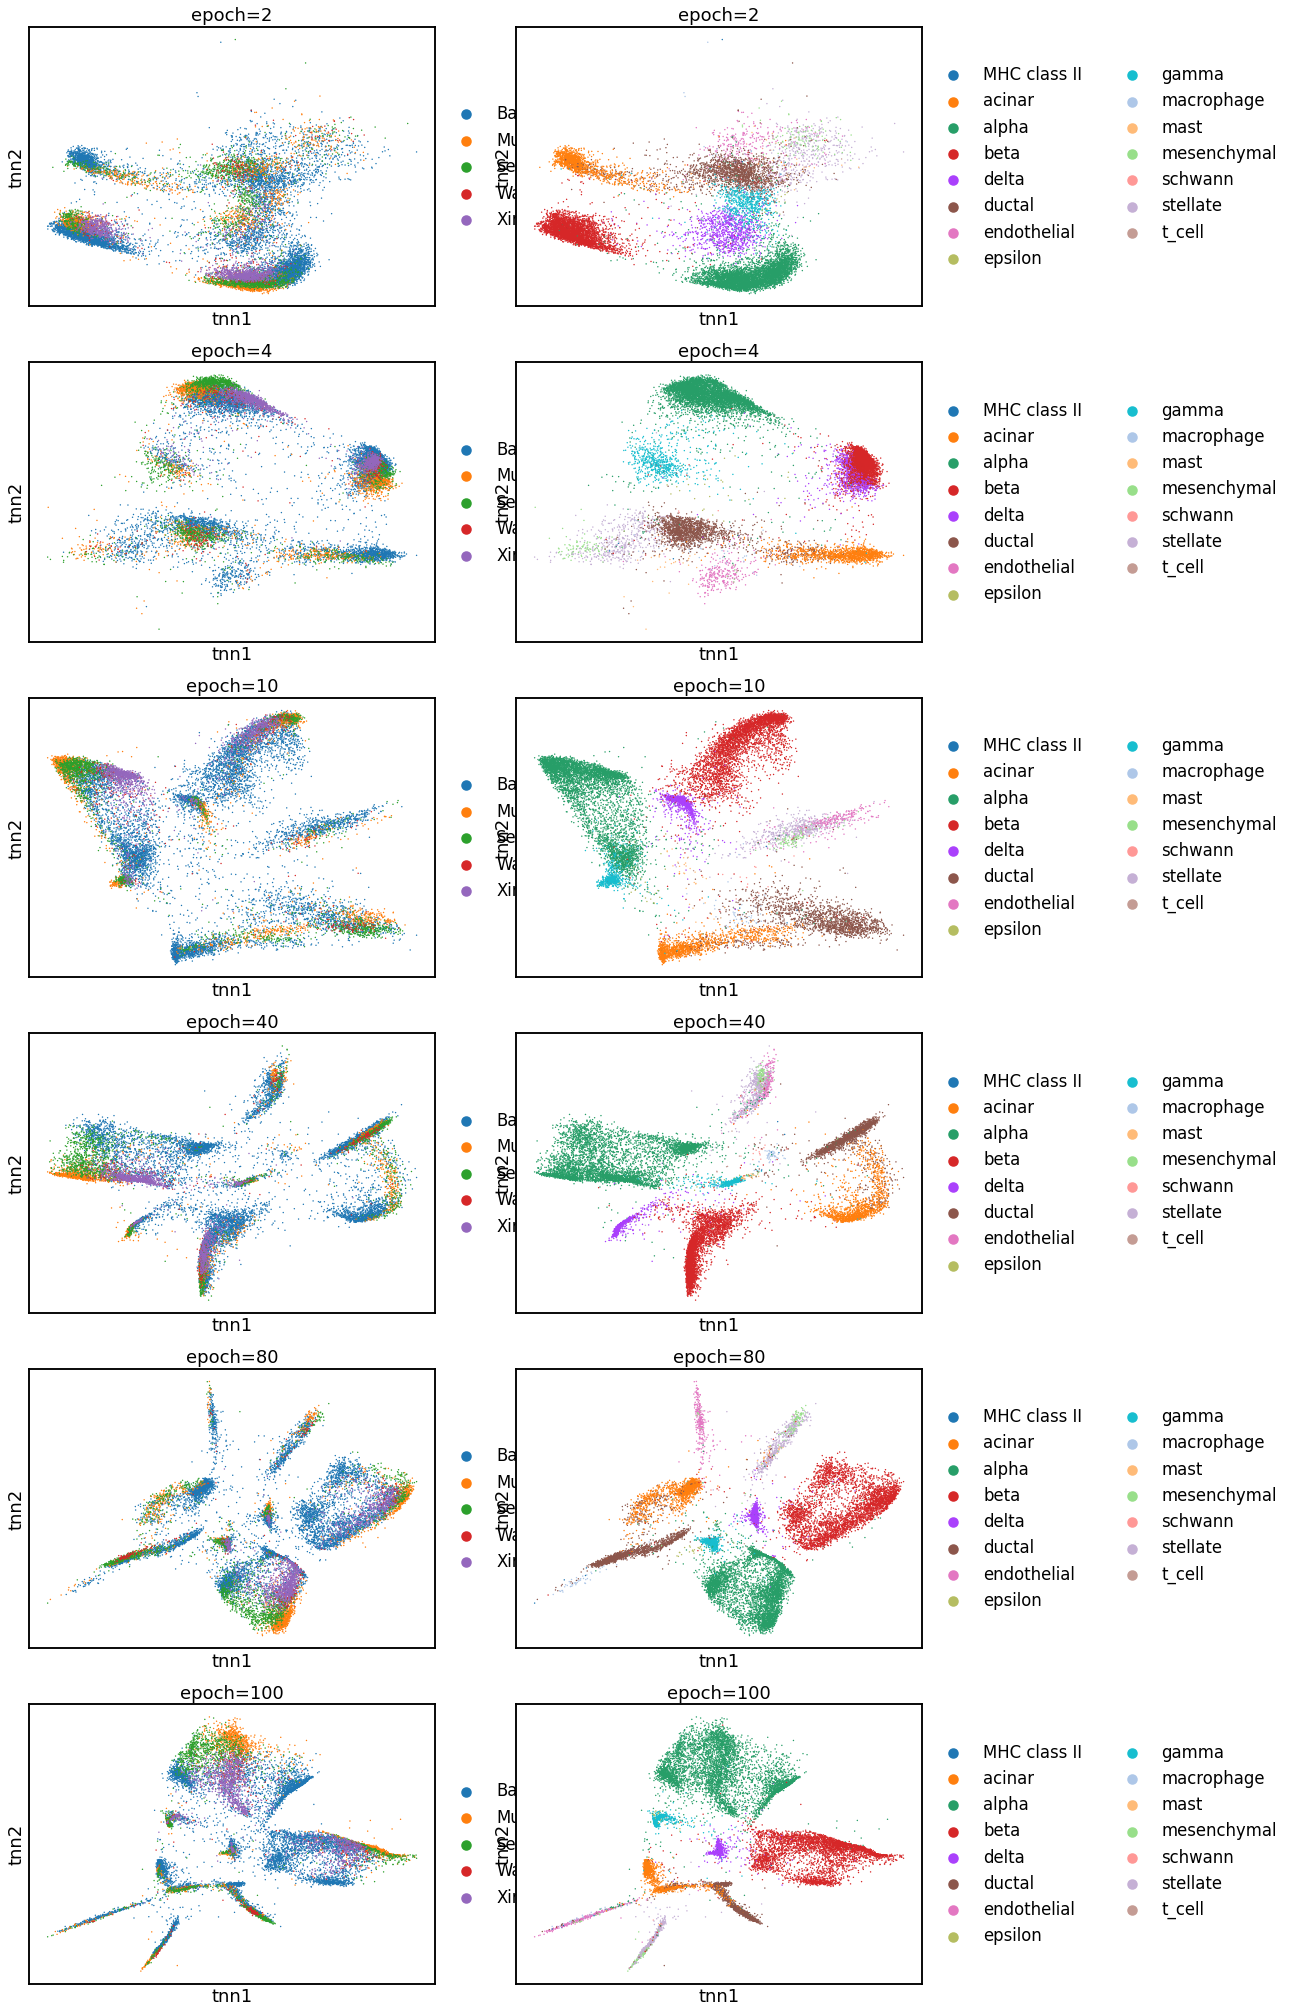

In [4]:
fig2